# Movie List Recommender using Actor-critic based RL method
> Training a list-wise movie recommender using actor-critic policy and evaluating offline using experience replay method

- toc: true
- badges: true
- comments: true
- categories: [RL, Movie, Tensorflow 1x]
- image:

### Introduction

We will model the sequential interactions between users and a recommender system as a Markov Decision Process (MDP) and leverage Reinforcement Learning (RL) to automatically learn the optimal strategies via recommending trial-and-error items and receiving reinforcements of these items from users’ feedbacks.

Efforts have been made on utilizing reinforcement learning for recommender systems, such as POMDP and Q-learning. However, these methods may become inflexible with the increasing number of items for recommendations. This prevents them to be adopted by practical recommender systems.

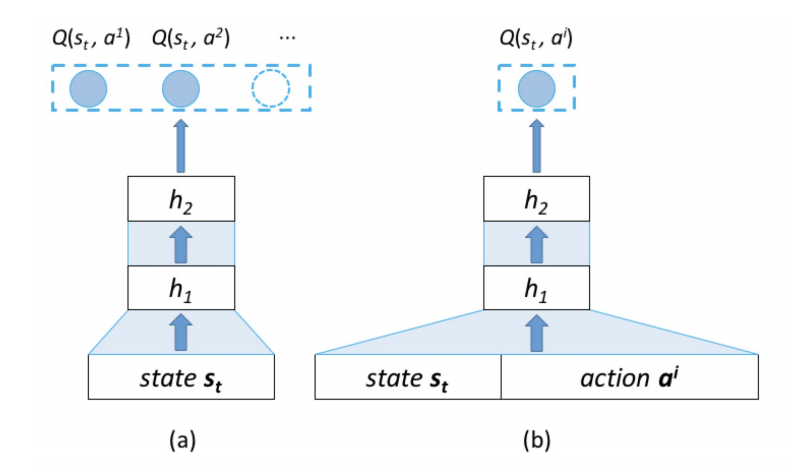


Generally, there exist two Deep Q-learning architectures, shown in the above figure. Traditional deep Q-learning adopts the first architecture as shown in (a), which inputs only the state space and outputs Q-values of all actions. This architecture is suitable for the scenario with high state space and small action space, like playing Atari. However, one drawback is that it cannot handle large and dynamic action space scenario, like recommender systems. The second Q-learning architecture, shown (b), treats the state and the action as the input of Neural Networks and outputs the Q-value corresponding to this action. This architecture does not need to store each Q-value in memory and thus can deal with large action space or even continuous action space. A challenging problem of leveraging the second architecture is temporal complexity, i.e., this architecture computes Q-value for all potential actions, separately.

Recommending a list of items is more desirable (especially for sellers) than recommending a single item. To achieve this, one option is to score the items seperately and select the top ones. For example, DQN can calculate Q-values of all recalled items separately, and recommend a list of items with highest Q-values. But this strategy do not consider the relation between items. e.g. If the next best item is egg, all kind of different eggs will get high scores, like white eggs, brown eggs, farm eggs etc. But these are similar items, not complimentary. And the whole purpose of list-wise recommendation is to recommend complimentary items. That's where DQN fails. 

One option to resolve this issue is by adding a simple rule - select only 1 top-scoring item from each category. This is a good rule and will improve the list quality but we have to compromise with some missed opportunities here because let's say we recommend a 12-brown-eggs 🥚 tray and a small brown bread 🍞. Now it is possible that if a 24-brown-eggs tray is scored higher than 12-brown-eggs tray but in bread category, small-brown-bread is still the highest score item. As per business sense, we should recommend a large brown bread with 24-brown-eggs tray. This is what we missed - either customer will manually select the large bread (lost opportunity for higher customer satisfaction) or just buy the small one (lost opportunity for higher revenue). 

In this tutorial, our goal is to fill this gap. We will evaluate the RL agent offline using experience replay method. Also, it is possible that productionizing this model cost more than the benefit, especially for small businesses, because if we are getting 1% revenue gain, on $1M, it might not be sufficient, and on $1B, the same model will become one of the highest priority model to productionize 💵.

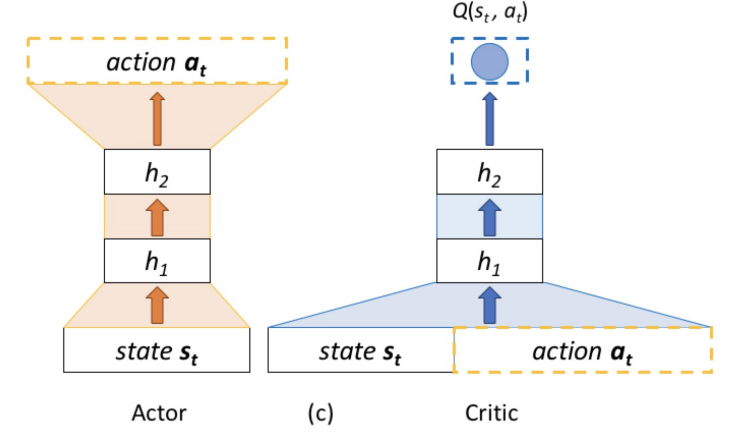

To tackle this problem, in this paper, our recommending policy builds upon the Actor-Critic framework. We model this problem as a Markov Decision Process (MDP), which includes a sequence of states, actions and rewards. More formally, MDP consists of a tuple of five elements $(\mathcal{S}, \mathcal{A}, \mathcal{P}, \mathcal{R}, \gamma)$ as follows:

- State space $\mathcal{S}$: A state $s_t \in S$ is defined as the browsing history of a user, i.e., previous $N$ items that a user browsed before time $t$. The items in $s_t$ are sorted in chronological order.
- Action space $\mathcal{A}$: An action $a_t \in \mathcal{A}$ is to recommend a list of items to a user at time $t$ based on current state $s_t$.
- Reward $\mathcal{R}$: After the recommender agent takes an action $a_t$ at the state $s_t$ , i.e., recommending a list of items to a user, the user browses these items and provides her feedback. She can skip (not click), click, or order these items, and the agent receives immediate reward $r(s_t,a_t)$ according to the user’s feedback.
- Transition probability $\mathcal{P}$: Transition probability defines the probability of state transition from $s_t$ to $s_{t+1}$ when RA takes action $a_t$. If user skips all the recommended items, then the next state $s_{t+1}$ = $s_t$; while if the user clicks/orders part of items, then the next state $s_{t+1}$ updates.
- Discount factor $\gamma$ : $\gamma \in [0,1]$ defines the discount factor when we measure the present value of future reward. In particular, when $\gamma$ = 0, RA only considers the immediate reward. In other words, when $\gamma$ = 1, all future rewards can be counted fully into that of the current action.

With the notations and definitions above, the problem of listwise item recommendation can be formally de!ned as follows: Given the historical MDP, i.e., $(\mathcal{S}, \mathcal{A}, \mathcal{P}, \mathcal{R}, \gamma)$, the goal is to find a recommendation policy $\pi : \mathcal{S} \to A$, which can maximize the cumulative reward for the recommender system.

According to collaborative filtering techniques, users with similar interests will make similar decisions on the same item. With this intuition, we match the current state and action to existing historical state-action pairs, and stochastically generate a simulated reward. To be more specific, we first build a memory $M = {m_1,m_2, ···}$ to store users’ historical browsing history, where $m_i$ is a user-agent interaction triplet $((s_i, a_i) \to r_i)$. The procedure to build the online simulator memory is illustrated in the following figure. Given a historical recommendation session ${a_1, ··· , a_L}$, we can observe the initial state $s_0 = {s_0^1, ··· ,s_0^N}$ from the previous sessions (line 2). Each time we observe $K$ items in temporal order (line 3), which means that each iteration we will move forward a window of K. We can observe the current state (line 4), current $K$ items (line 5), and the user’s feedbacks for these items (line 6). Then we store triplet $((s_i, a_i) \to r_i)$ in memory (line 7). Finally we update the state (lines 8-13), and move to the next $K$ items. Since we keep a fixed length state $s = {s_1, ··· ,s_N }$, each time a user clicked/ordered some items in the recommended list, we add these items to the end of state and remove the same number of items in the top of the state. For example, the RA recommends a list of !ve items ${a_1, ··· , a_5}$ to a user, if the user clicks $a_1$ and orders $a_5$, then update $s = {s_3, ··· ,s_N , a_1, a_5}$.

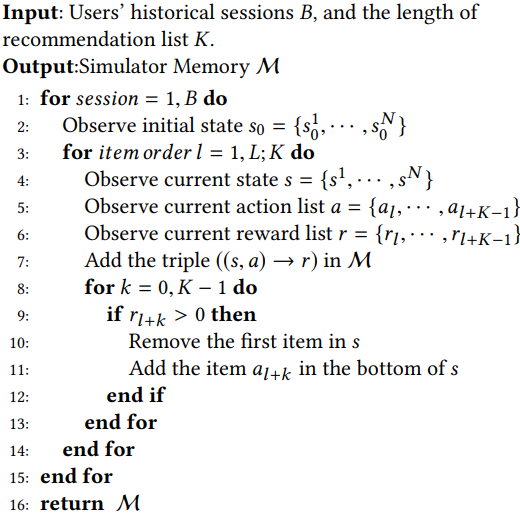

Then we calculated the similarity of the current state-action pair, say $p_t(s_t,a_t)$, to each existing historical state-action pair in the memory. In this work, we adopt cosine similarity as:

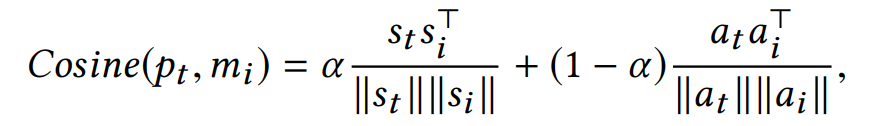

where the first term measures the state similarity and the second term evaluates the action similarity. Parameter $\alpha$ controls the balance of two similarities.

The proposed framework is as follows:

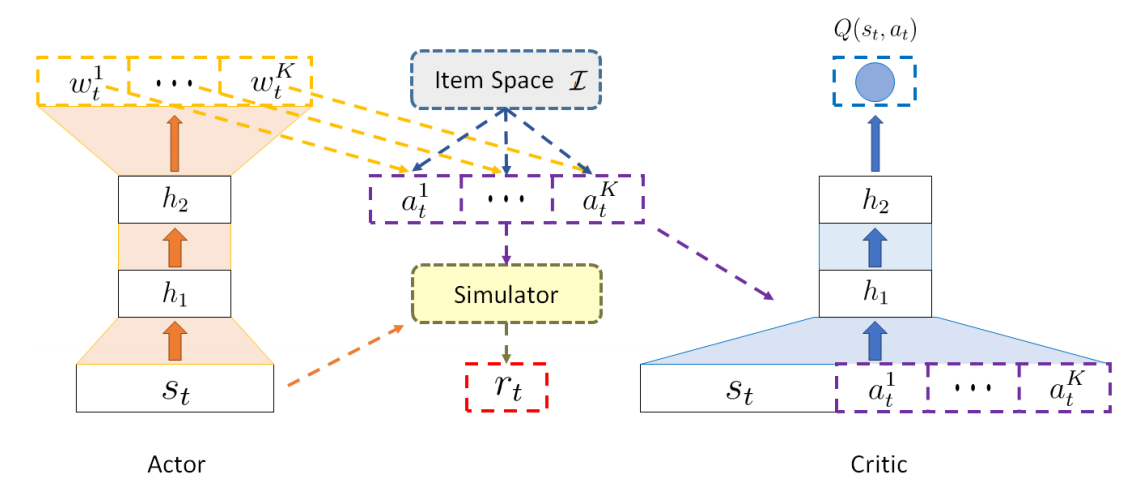

The framework works like this:

**Input**: Current state $s_t$ , Item space $\mathcal{I}$, the length of recommendation list $K$.
**Output**: Recommendation list $a_t$.

1. Generate $w_t = {w_t^1 , ··· , w_t^K}$ according to $f_\theta\pi : s_t \to w_t$ where $f_\theta\pi$ is a function parametrized by $\theta^\pi$, mapping from the state space to the weight representation space
2. For $k = 1:K$ do
    1. Score items in $\mathcal{I}$ according to $score_i = w_t^ke_i^T$
    2. Select an item with highest score $a_t^k$
    3. Add item $a_t^k$ in the bottom of $a_t$
    4. Remove item $a_t^k$ from $\mathcal{I}$
3. end for
4. return $a_t$

### Setup

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import itertools
import pandas as pd
import numpy as np
import random
import csv
import time

import matplotlib.pyplot as plt

import tensorflow as tf

import keras.backend as K
from keras import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


### Download data

Downloading Movielens dataset from official source

In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -q ml-100k.zip

### DataGenerator `class`
1. Load the data into pandas dataframe
2. List down user's rating history in chronological order
3. Generate a sample of state-action pair
4. Split the data into train/test
5. Store the data back into csv file format

In [ ]:
#collapse-hide
class DataGenerator():
  def __init__(self, datapath, itempath):
    '''
    Load data from the DB MovieLens
    List the users and the items
    List all the users histories
    '''
    self.data  = self.load_data(datapath, itempath)
    self.users = self.data['userId'].unique()   #list of all users
    self.items = self.data['itemId'].unique()   #list of all items
    self.histo = self.generate_history()
    self.train = []
    self.test  = []

  def load_data(self, datapath, itempath):
    '''
    Load the data and merge the name of each movie. 
    A row corresponds to a rate given by a user to a movie.

     Parameters
    ----------
    datapath :  string
                path to the data 100k MovieLens
                contains usersId;itemId;rating 
    itempath :  string
                path to the data 100k MovieLens
                contains itemId;itemName
     Returns
    -------
    result :    DataFrame
                Contains all the ratings 
    '''
    data = pd.read_csv(datapath, sep='\t', 
                       names=['userId', 'itemId', 'rating', 'timestamp'])
    movie_titles = pd.read_csv(itempath, sep='|', names=['itemId', 'itemName'],
                           usecols=range(2), encoding='latin-1')
    return data.merge(movie_titles,on='itemId', how='left')


  def generate_history(self):
    '''
    Group all rates given by users and store them from older to most recent.
    
    Returns
    -------
    result :    List(DataFrame)
                List of the historic for each user
    '''
    historic_users = []
    for i, u in enumerate(self.users):
      temp = self.data[self.data['userId'] == u]
      temp = temp.sort_values('timestamp').reset_index()
      temp.drop('index', axis=1, inplace=True)
      historic_users.append(temp)
    return historic_users

  def sample_history(self, user_histo, action_ratio=0.8, max_samp_by_user=5,  max_state=100, max_action=50, nb_states=[], nb_actions=[]):
    '''
    For a given history, make one or multiple sampling.
    If no optional argument given for nb_states and nb_actions, then the sampling
    is random and each sample can have differents size for action and state.
    To normalize sampling we need to give list of the numbers of states and actions
    to be sampled.

    Parameters
    ----------
    user_histo :  DataFrame
                      historic of user
    delimiter :       string, optional
                      delimiter for the csv
    action_ratio :    float, optional
                      ratio form which movies in history will be selected
    max_samp_by_user: int, optional
                      Nulber max of sample to make by user
    max_state :       int, optional
                      Number max of movies to take for the 'state' column
    max_action :      int, optional
                      Number max of movies to take for the 'action' action
    nb_states :       array(int), optional
                      Numbers of movies to be taken for each sample made on user's historic
    nb_actions :      array(int), optional
                      Numbers of rating to be taken for each sample made on user's historic
    
    Returns
    -------
    states :         List(String)
                     All the states sampled, format of a sample: itemId&rating
    actions :        List(String)
                     All the actions sampled, format of a sample: itemId&rating
  

    Notes
    -----
    States must be before(timestamp<) the actions.
    If given, size of nb_states is the numbller of sample by user
    sizes of nb_states and nb_actions must be equals
    '''

    n = len(user_histo)
    sep = int(action_ratio * n)
    nb_sample = random.randint(1, max_samp_by_user)
    if not nb_states:
      nb_states = [min(random.randint(1, sep), max_state) for i in range(nb_sample)]
    if not nb_actions:
      nb_actions = [min(random.randint(1, n - sep), max_action) for i in range(nb_sample)]
    assert len(nb_states) == len(nb_actions), 'Given array must have the same size'
    
    states  = []
    actions = []
    # SELECT SAMPLES IN HISTORY
    for i in range(len(nb_states)):
      sample_states = user_histo.iloc[0:sep].sample(nb_states[i])
      sample_actions = user_histo.iloc[-(n - sep):].sample(nb_actions[i])
      
      sample_state =  []
      sample_action = []
      for j in range(nb_states[i]):
        row   = sample_states.iloc[j]
        # FORMAT STATE
        state = str(row.loc['itemId']) + '&' + str(row.loc['rating'])
        sample_state.append(state)
      
      for j in range(nb_actions[i]):
        row    = sample_actions.iloc[j]
        # FORMAT ACTION
        action = str(row.loc['itemId']) + '&' + str(row.loc['rating'])
        sample_action.append(action)

      states.append(sample_state)
      actions.append(sample_action)
    return states, actions

  def gen_train_test(self, test_ratio, seed=None):
    '''
    Shuffle the historic of users and separate it in a train and a test set.
    Store the ids for each set.
    An user can't be in both set.

     Parameters
    ----------
    test_ratio :  float
                  Ratio to control the sizes of the sets
    seed       :  float
                  Seed on the shuffle
    '''
    n = len(self.histo)

    if seed is not None:
      random.Random(seed).shuffle(self.histo)
    else:
      random.shuffle(self.histo)

    self.train = self.histo[:int((test_ratio * n))]
    self.test  = self.histo[int((test_ratio * n)):]
    self.user_train = [h.iloc[0,0] for h in self.train]
    self.user_test  = [h.iloc[0,0] for h in self.test]
    

  def write_csv(self, filename, histo_to_write, delimiter=';', action_ratio=0.8, max_samp_by_user=5, max_state=100, max_action=50, nb_states=[], nb_actions=[]):
    '''
    From  a given historic, create a csv file with the format:
    columns : state;action_reward;n_state
    rows    : itemid&rating1 | itemid&rating2 | ... ; itemid&rating3 | ... | itemid&rating4; itemid&rating1 | itemid&rating2 | itemid&rating3 | ... | item&rating4
    at filename location.

    Parameters
    ----------
    filename :        string
                      path to the file to be produced
    histo_to_write :  List(DataFrame)
                      List of the historic for each user
    delimiter :       string, optional
                      delimiter for the csv
    action_ratio :    float, optional
                      ratio form which movies in history will be selected
    max_samp_by_user: int, optional
                      Nulber max of sample to make by user
    max_state :       int, optional
                      Number max of movies to take for the 'state' column
    max_action :      int, optional
                      Number max of movies to take for the 'action' action
    nb_states :       array(int), optional
                      Numbers of movies to be taken for each sample made on user's historic
    nb_actions :      array(int), optional
                      Numbers of rating to be taken for each sample made on user's historic

    Notes
    -----
    if given, size of nb_states is the numbller of sample by user
    sizes of nb_states and nb_actions must be equals

    '''
    with open(filename, mode='w') as file:
      f_writer = csv.writer(file, delimiter=delimiter)
      f_writer.writerow(['state', 'action_reward', 'n_state'])
      for user_histo in histo_to_write:
        states, actions = self.sample_history(user_histo, action_ratio, max_samp_by_user, max_state, max_action, nb_states, nb_actions)
        for i in range(len(states)):
          # FORMAT STATE
          state_str   = '|'.join(states[i])
          # FORMAT ACTION
          action_str  = '|'.join(actions[i])
          # FORMAT N_STATE
          n_state_str = state_str + '|' + action_str
          f_writer.writerow([state_str, action_str, n_state_str])

### EmbeddingsGenerator `class`
1. Load the data
2. Build a keras sequential model
3. Convert train and test set into required format
4. Train and evaluate the model
5. Generate item embeddings for each movie id
6. Save the embeddings into a csv file

In [ ]:
#collapse-hide
class EmbeddingsGenerator:
  def  __init__(self, train_users, data):
    self.train_users = train_users

    #preprocess
    self.data = data.sort_values(by=['timestamp'])
    #make them start at 0
    self.data['userId'] = self.data['userId'] - 1
    self.data['itemId'] = self.data['itemId'] - 1
    self.user_count = self.data['userId'].max() + 1
    self.movie_count = self.data['itemId'].max() + 1
    self.user_movies = {} #list of rated movies by each user
    for userId in range(self.user_count):
      self.user_movies[userId] = self.data[self.data.userId == userId]['itemId'].tolist()
    self.m = self.model()

  def model(self, hidden_layer_size=100):
    m = Sequential()
    m.add(Dense(hidden_layer_size, input_shape=(1, self.movie_count)))
    m.add(Dropout(0.2))
    m.add(Dense(self.movie_count, activation='softmax'))
    m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return m
  
  def generate_input(self, user_id):
    '''
    Returns a context and a target for the user_id
    context: user's history with one random movie removed
    target: id of random removed movie
    '''
    user_movies_count = len(self.user_movies[user_id])
    #picking random movie
    random_index = np.random.randint(0, user_movies_count-1) # -1 avoids taking the last movie
    #setting target
    target = np.zeros((1, self.movie_count))
    target[0][self.user_movies[user_id][random_index]] = 1
    #setting context
    context = np.zeros((1, self.movie_count))
    context[0][self.user_movies[user_id][:random_index] + self.user_movies[user_id][random_index+1:]] = 1
    return context, target

  def train(self, nb_epochs = 300, batch_size = 10000):
    '''
    Trains the model from train_users's history
    '''
    for i in range(nb_epochs):
      print('%d/%d' % (i+1, nb_epochs))
      batch = [self.generate_input(user_id=np.random.choice(self.train_users) - 1) for _ in range(batch_size)]
      X_train = np.array([b[0] for b in batch])
      y_train = np.array([b[1] for b in batch])
      self.m.fit(X_train, y_train, epochs=1, validation_split=0.5)

  def test(self, test_users, batch_size = 100000):
    '''
    Returns [loss, accuracy] on the test set
    '''
    batch_test = [self.generate_input(user_id=np.random.choice(test_users) - 1) for _ in range(batch_size)]
    X_test = np.array([b[0] for b in batch_test])
    y_test = np.array([b[1] for b in batch_test])
    return self.m.evaluate(X_test, y_test)

  def save_embeddings(self, file_name):
    '''
    Generates a csv file containg the vector embedding for each movie.
    '''
    inp = self.m.input                                           # input placeholder
    outputs = [layer.output for layer in self.m.layers]          # all layer outputs
    functor = K.function([inp, K.learning_phase()], outputs )   # evaluation function

    #append embeddings to vectors
    vectors = []
    for movie_id in range(self.movie_count):
      movie = np.zeros((1, 1, self.movie_count))
      movie[0][0][movie_id] = 1
      layer_outs = functor([movie])
      vector = [str(v) for v in layer_outs[0][0][0]]
      vector = '|'.join(vector)
      vectors.append([movie_id, vector])

    #saves as a csv file
    embeddings = pd.DataFrame(vectors, columns=['item_id', 'vectors']).astype({'item_id': 'int32'})
    embeddings.to_csv(file_name, sep=';', index=False)

### Embeddings `helper class`

In [ ]:
#collapse-hide
class Embeddings:
  def __init__(self, item_embeddings):
    self.item_embeddings = item_embeddings
  
  def size(self):
    return self.item_embeddings.shape[1]
  
  def get_embedding_vector(self):
    return self.item_embeddings
  
  def get_embedding(self, item_index):
    return self.item_embeddings[item_index]

  def embed(self, item_list):
    return np.array([self.get_embedding(item) for item in item_list])

### read_file `helper function`

This function will read the stored data csv files into pandas dataframe

In [ ]:
#collapse-hide
def read_file(data_path):
  ''' Load data from train.csv or test.csv. '''

  data = pd.read_csv(data_path, sep=';')
  for col in ['state', 'n_state', 'action_reward']:
    data[col] = [np.array([[np.int(k) for k in ee.split('&')] for ee in e.split('|')]) for e in data[col]]
  for col in ['state', 'n_state']:
    data[col] = [np.array([e[0] for e in l]) for l in data[col]]

  data['action'] = [[e[0] for e in l] for l in data['action_reward']]
  data['reward'] = [tuple(e[1] for e in l) for l in data['action_reward']]
  data.drop(columns=['action_reward'], inplace=True)

  return data

### read_embeddings `helper function`

This function will read the stored embedding csv file into pandas dataframe and return as multi-dimensional array

In [ ]:
def read_embeddings(embeddings_path):
  ''' Load embeddings (a vector for each item). '''
  
  embeddings = pd.read_csv(embeddings_path, sep=';')

  return np.array([[np.float64(k) for k in e.split('|')]
                   for e in embeddings['vectors']])

### Environment `class`

This is the simulator. It will help orchestrating the whole process of learning list recommendations by our actor-critic based MDP agent. 

In [ ]:
#collapse-hide
class Environment():
  def __init__(self, data, embeddings, alpha, gamma, fixed_length):
    self.embeddings = embeddings

    self.embedded_data = pd.DataFrame()
    self.embedded_data['state'] = [np.array([embeddings.get_embedding(item_id) 
      for item_id in row['state']]) for _, row in data.iterrows()]
    self.embedded_data['action'] = [np.array([embeddings.get_embedding(item_id) 
      for item_id in row['action']]) for _, row in data.iterrows()]
    self.embedded_data['reward'] = data['reward']

    self.alpha = alpha # α (alpha) in Equation (1)
    self.gamma = gamma # Γ (Gamma) in Equation (4)
    self.fixed_length = fixed_length
    self.current_state = self.reset()
    self.groups = self.get_groups()

  def reset(self):
    self.init_state = self.embedded_data['state'].sample(1).values[0]
    return self.init_state

  def step(self, actions):
    '''
    Compute reward and update state.
    Args:
      actions: embedded chosen items.
    Returns:
      cumulated_reward: overall reward.
      current_state: updated state.
    '''

    # '18: Compute overall reward r_t according to Equation (4)'
    simulated_rewards, cumulated_reward = self.simulate_rewards(self.current_state.reshape((1, -1)), actions.reshape((1, -1)))

    # '11: Set s_t+1 = s_t' <=> self.current_state = self.current_state

    for k in range(len(simulated_rewards)): # '12: for k = 1, K do'
      if simulated_rewards[k] > 0: # '13: if r_t^k > 0 then'
        # '14: Add a_t^k to the end of s_t+1'
        self.current_state = np.append(self.current_state, [actions[k]], axis=0)
        if self.fixed_length: # '15: Remove the first item of s_t+1'
          self.current_state = np.delete(self.current_state, 0, axis=0)

    return cumulated_reward, self.current_state

  def get_groups(self):
    ''' Calculate average state/action value for each group. Equation (3). '''

    groups = []
    for rewards, group in self.embedded_data.groupby(['reward']):
      size = group.shape[0]
      states = np.array(list(group['state'].values))
      actions = np.array(list(group['action'].values))
      groups.append({
        'size': size, # N_x in article
        'rewards': rewards, # U_x in article (combination of rewards)
        'average state': (np.sum(states / np.linalg.norm(states, 2, axis=1)[:, np.newaxis], axis=0) / size).reshape((1, -1)), # s_x^-
        'average action': (np.sum(actions / np.linalg.norm(actions, 2, axis=1)[:, np.newaxis], axis=0) / size).reshape((1, -1)) # a_x^-
      })
    return groups

  def simulate_rewards(self, current_state, chosen_actions, reward_type='grouped cosine'):
    '''
    Calculate simulated rewards.
    Args:
      current_state: history, list of embedded items.
      chosen_actions: embedded chosen items.
      reward_type: from ['normal', 'grouped average', 'grouped cosine'].
    Returns:
      returned_rewards: most probable rewards.
      cumulated_reward: probability weighted rewards.
    '''

    # Equation (1)
    def cosine_state_action(s_t, a_t, s_i, a_i):
      cosine_state = np.dot(s_t, s_i.T) / (np.linalg.norm(s_t, 2) * np.linalg.norm(s_i, 2))
      cosine_action = np.dot(a_t, a_i.T) / (np.linalg.norm(a_t, 2) * np.linalg.norm(a_i, 2))
      return (self.alpha * cosine_state + (1 - self.alpha) * cosine_action).reshape((1,))

    if reward_type == 'normal':
      # Calculate simulated reward in normal way: Equation (2)
      probabilities = [cosine_state_action(current_state, chosen_actions, row['state'], row['action'])
        for _, row in self.embedded_data.iterrows()]
    elif reward_type == 'grouped average':
      # Calculate simulated reward by grouped average: Equation (3)
      probabilities = np.array([g['size'] for g in self.groups]) *\
        [(self.alpha * (np.dot(current_state, g['average state'].T) / np.linalg.norm(current_state, 2))\
        + (1 - self.alpha) * (np.dot(chosen_actions, g['average action'].T) / np.linalg.norm(chosen_actions, 2)))
        for g in self.groups]
    elif reward_type == 'grouped cosine':
      # Calculate simulated reward by grouped cosine: Equations (1) and (3)
      probabilities = [cosine_state_action(current_state, chosen_actions, g['average state'], g['average action'])
        for g in self.groups]

    # Normalize (sum to 1)
    probabilities = np.array(probabilities) / sum(probabilities)

    # Get most probable rewards
    if reward_type == 'normal':
      returned_rewards = self.embedded_data.iloc[np.argmax(probabilities)]['reward']
    elif reward_type in ['grouped average', 'grouped cosine']:
      returned_rewards = self.groups[np.argmax(probabilities)]['rewards']

    # Equation (4)
    def overall_reward(rewards, gamma):
      return np.sum([gamma**k * reward for k, reward in enumerate(rewards)])

    if reward_type in ['normal', 'grouped average']:
      # Get cumulated reward: Equation (4)
      cumulated_reward = overall_reward(returned_rewards, self.gamma)
    elif reward_type == 'grouped cosine':
      # Get probability weighted cumulated reward
      cumulated_reward = np.sum([p * overall_reward(g['rewards'], self.gamma)
        for p, g in zip(probabilities, self.groups)])

    return returned_rewards, cumulated_reward

### Actor `class`

This is the policy approximator actor 

In [ ]:
#collapse-hide
class Actor():
  ''' Policy function approximator. '''
  
  def __init__(self, sess, state_space_size, action_space_size, batch_size, ra_length, history_length, embedding_size, tau, learning_rate, scope='actor'):
    self.sess = sess
    self.state_space_size = state_space_size
    self.action_space_size = action_space_size
    self.batch_size = batch_size
    self.ra_length = ra_length
    self.history_length = history_length
    self.embedding_size = embedding_size
    self.tau = tau
    self.learning_rate = learning_rate
    self.scope = scope

    with tf.variable_scope(self.scope):
      # Build Actor network
      self.action_weights, self.state, self.sequence_length = self._build_net('estimator_actor')
      self.network_params = tf.trainable_variables()

      # Build target Actor network
      self.target_action_weights, self.target_state, self.target_sequence_length = self._build_net('target_actor')
      self.target_network_params = tf.trainable_variables()[len(self.network_params):] # TODO: why sublist [len(x):]? Maybe because its equal to network_params + target_network_params

      # Initialize target network weights with network weights (θ^π′ ← θ^π)
      self.init_target_network_params = [self.target_network_params[i].assign(self.network_params[i])
        for i in range(len(self.target_network_params))]
        
      # Update target network weights (θ^π′ ← τθ^π + (1 − τ)θ^π′)
      self.update_target_network_params = [self.target_network_params[i].assign(
        tf.multiply(self.tau, self.network_params[i]) +
        tf.multiply(1 - self.tau, self.target_network_params[i]))
        for i in range(len(self.target_network_params))]

      # Gradient computation from Critic's action_gradients
      self.action_gradients = tf.placeholder(tf.float32, [None, self.action_space_size])
      gradients = tf.gradients(tf.reshape(self.action_weights, [self.batch_size, self.action_space_size], name='42222222222'),
                               self.network_params,
                               self.action_gradients)
      params_gradients = list(map(lambda x: tf.div(x, self.batch_size * self.action_space_size), gradients))
      
      # Compute ∇_a.Q(s, a|θ^µ).∇_θ^π.f_θ^π(s)
      self.optimizer = tf.train.AdamOptimizer(self.learning_rate).apply_gradients(
          zip(params_gradients, self.network_params))

  def _build_net(self, scope):
    ''' Build the (target) Actor network. '''

    def gather_last_output(data, seq_lens):
      def cli_value(x, v):
        y = tf.constant(v, shape=x.get_shape(), dtype=tf.int64)
        x = tf.cast(x, tf.int64)
        return tf.where(tf.greater(x, y), x, y)

      batch_range = tf.range(tf.cast(tf.shape(data)[0], dtype=tf.int64), dtype=tf.int64)
      tmp_end = tf.map_fn(lambda x: cli_value(x, 0), seq_lens - 1, dtype=tf.int64)
      indices = tf.stack([batch_range, tmp_end], axis=1)
      return tf.gather_nd(data, indices)

    with tf.variable_scope(scope):
      # Inputs: current state, sequence_length
      # Outputs: action weights to compute the score Equation (6)
      state = tf.placeholder(tf.float32, [None, self.state_space_size], 'state')
      state_ = tf.reshape(state, [-1, self.history_length, self.embedding_size])
      sequence_length = tf.placeholder(tf.int32, [None], 'sequence_length')
      cell = tf.nn.rnn_cell.GRUCell(self.embedding_size,
                                    activation=tf.nn.relu,
                                    kernel_initializer=tf.initializers.random_normal(),
                                    bias_initializer=tf.zeros_initializer())
      outputs, _ = tf.nn.dynamic_rnn(cell, state_, dtype=tf.float32, sequence_length=sequence_length)
      last_output = gather_last_output(outputs, sequence_length) # TODO: replace by h
      x = tf.keras.layers.Dense(self.ra_length * self.embedding_size)(last_output)
      action_weights = tf.reshape(x, [-1, self.ra_length, self.embedding_size])

    return action_weights, state, sequence_length

  def train(self, state, sequence_length, action_gradients):
    '''  Compute ∇_a.Q(s, a|θ^µ).∇_θ^π.f_θ^π(s). '''
    self.sess.run(self.optimizer,
                  feed_dict={
                      self.state: state,
                      self.sequence_length: sequence_length,
                      self.action_gradients: action_gradients})

  def predict(self, state, sequence_length):
    return self.sess.run(self.action_weights,
                         feed_dict={
                             self.state: state,
                             self.sequence_length: sequence_length})

  def predict_target(self, state, sequence_length):
    return self.sess.run(self.target_action_weights,
                         feed_dict={
                             self.target_state: state,
                             self.target_sequence_length: sequence_length})

  def init_target_network(self):
    self.sess.run(self.init_target_network_params)

  def update_target_network(self):
    self.sess.run(self.update_target_network_params)
    
  def get_recommendation_list(self, ra_length, noisy_state, embeddings, target=False):
    '''
    Algorithm 2
    Args:
      ra_length: length of the recommendation list.
      noisy_state: current/remembered environment state with noise.
      embeddings: Embeddings object.
      target: boolean to use Actor's network or target network.
    Returns:
      Recommendation List: list of embedded items as future actions.
    '''

    def get_score(weights, embedding, batch_size):
      '''
      Equation (6)
      Args:
        weights: w_t^k shape=(embedding_size,).
        embedding: e_i shape=(embedding_size,).
      Returns:
        score of the item i: score_i=w_t^k.e_i^T shape=(1,).
      '''
      ret = np.dot(weights, embedding.T)
      return ret

    batch_size = noisy_state.shape[0]

    # '1: Generate w_t = {w_t^1, ..., w_t^K} according to Equation (5)'
    method = self.predict_target if target else self.predict
    weights = method(noisy_state, [ra_length] * batch_size)

    # '3: Score items in I according to Equation (6)'
    scores = np.array([[[get_score(weights[i][k], embedding, batch_size)
      for embedding in embeddings.get_embedding_vector()]
      for k in range(ra_length)]
      for i in range(batch_size)])

    # '8: return a_t'
    return np.array([[embeddings.get_embedding(np.argmax(scores[i][k]))
      for k in range(ra_length)]
      for i in range(batch_size)])

### Critic `class`

This is the value approximator critic

In [ ]:
#collapse-hide
class Critic():
  ''' Value function approximator. '''
  
  def __init__(self, sess, state_space_size, action_space_size, history_length, embedding_size, tau, learning_rate, scope='critic'):
    self.sess = sess
    self.state_space_size = state_space_size
    self.action_space_size = action_space_size
    self.history_length = history_length
    self.embedding_size = embedding_size
    self.tau = tau
    self.learning_rate = learning_rate
    self.scope = scope

    with tf.variable_scope(self.scope):
      # Build Critic network
      self.critic_Q_value, self.state, self.action, self.sequence_length = self._build_net('estimator_critic')
      self.network_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='estimator_critic')

      # Build target Critic network
      self.target_Q_value, self.target_state, self.target_action, self.target_sequence_length = self._build_net('target_critic')
      self.target_network_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='target_critic')

      # Initialize target network weights with network weights (θ^µ′ ← θ^µ)
      self.init_target_network_params = [self.target_network_params[i].assign(self.network_params[i])
        for i in range(len(self.target_network_params))]

      # Update target network weights (θ^µ′ ← τθ^µ + (1 − τ)θ^µ′)
      self.update_target_network_params = [self.target_network_params[i].assign(
        tf.multiply(self.tau, self.network_params[i]) +
        tf.multiply(1 - self.tau, self.target_network_params[i]))
        for i in range(len(self.target_network_params))]

      # Minimize MSE between Critic's and target Critic's outputed Q-values
      self.expected_reward = tf.placeholder(tf.float32, [None, 1])
      self.loss = tf.reduce_mean(tf.squared_difference(self.expected_reward, self.critic_Q_value))
      self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

      # Compute ∇_a.Q(s, a|θ^µ)
      self.action_gradients = tf.gradients(self.critic_Q_value, self.action)

  def _build_net(self, scope):
    ''' Build the (target) Critic network. '''

    def gather_last_output(data, seq_lens):
      def cli_value(x, v):
        y = tf.constant(v, shape=x.get_shape(), dtype=tf.int64)
        return tf.where(tf.greater(x, y), x, y)

      this_range = tf.range(tf.cast(tf.shape(seq_lens)[0], dtype=tf.int64), dtype=tf.int64)
      tmp_end = tf.map_fn(lambda x: cli_value(x, 0), seq_lens - 1, dtype=tf.int64)
      indices = tf.stack([this_range, tmp_end], axis=1)
      return tf.gather_nd(data, indices)

    with tf.variable_scope(scope):
      # Inputs: current state, current action
      # Outputs: predicted Q-value
      state = tf.placeholder(tf.float32, [None, self.state_space_size], 'state')
      state_ = tf.reshape(state, [-1, self.history_length, self.embedding_size])
      action = tf.placeholder(tf.float32, [None, self.action_space_size], 'action')
      sequence_length = tf.placeholder(tf.int64, [None], name='critic_sequence_length')
      cell = tf.nn.rnn_cell.GRUCell(self.history_length,
                                    activation=tf.nn.relu,
                                    kernel_initializer=tf.initializers.random_normal(),
                                    bias_initializer=tf.zeros_initializer())
      predicted_state, _ = tf.nn.dynamic_rnn(cell, state_, dtype=tf.float32, sequence_length=sequence_length)
      predicted_state = gather_last_output(predicted_state, sequence_length)

      inputs = tf.concat([predicted_state, action], axis=-1)
      layer1 = tf.layers.Dense(32, activation=tf.nn.relu)(inputs)
      layer2 = tf.layers.Dense(16, activation=tf.nn.relu)(layer1)
      critic_Q_value = tf.layers.Dense(1)(layer2)
      return critic_Q_value, state, action, sequence_length

  def train(self, state, action, sequence_length, expected_reward):
    ''' Minimize MSE between expected reward and target Critic's Q-value. '''
    return self.sess.run([self.critic_Q_value, self.loss, self.optimizer],
                         feed_dict={
                             self.state: state,
                             self.action: action,
                             self.sequence_length: sequence_length,
                             self.expected_reward: expected_reward})

  def predict(self, state, action, sequence_length):
    ''' Returns Critic's predicted Q-value. '''
    return self.sess.run(self.critic_Q_value,
                         feed_dict={
                             self.state: state,
                             self.action: action,
                             self.sequence_length: sequence_length})

  def predict_target(self, state, action, sequence_length):
    ''' Returns target Critic's predicted Q-value. '''
    return self.sess.run(self.target_Q_value,
                         feed_dict={
                             self.target_state: state,
                             self.target_action: action,
                             self.target_sequence_length: sequence_length})

  def get_action_gradients(self, state, action, sequence_length):
    ''' Returns ∇_a.Q(s, a|θ^µ). '''
    return np.array(self.sess.run(self.action_gradients,
                         feed_dict={
                             self.state: state,
                             self.action: action,
                             self.sequence_length: sequence_length})[0])

  def init_target_network(self):
    self.sess.run(self.init_target_network_params)

  def update_target_network(self):
    self.sess.run(self.update_target_network_params)

### ReplayMemory `class`

In [ ]:
#collapse-hide
class ReplayMemory():
  ''' Replay memory D. '''
  
  def __init__(self, buffer_size):
    self.buffer_size = buffer_size
    # self.buffer = [[row['state'], row['action'], row['reward'], row['n_state']] for _, row in data.iterrows()][-self.buffer_size:] TODO: empty or not?
    self.buffer = []

  def add(self, state, action, reward, n_state):
    self.buffer.append([state, action, reward, n_state])
    if len(self.buffer) > self.buffer_size:
      self.buffer.pop(0)

  def size(self):
    return len(self.buffer)

  def sample_batch(self, batch_size):
    return random.sample(self.buffer, batch_size)

### experience_replay `function`

In [ ]:
#collapse-hide
def experience_replay(replay_memory, batch_size, actor, critic, embeddings, ra_length, state_space_size, action_space_size, discount_factor):
  '''
  Experience replay.
  Args:
    replay_memory: replay memory D in article.
    batch_size: sample size.
    actor: Actor network.
    critic: Critic network.
    embeddings: Embeddings object.
    state_space_size: dimension of states.
    action_space_size: dimensions of actions.
  Returns:
    Best Q-value, loss of Critic network for printing/recording purpose.
  '''

  # '22: Sample minibatch of N transitions (s, a, r, s′) from D'
  samples = replay_memory.sample_batch(batch_size)
  states = np.array([s[0] for s in samples])
  actions = np.array([s[1] for s in samples])
  rewards = np.array([s[2] for s in samples])
  n_states = np.array([s[3] for s in samples]).reshape(-1, state_space_size)

  # '23: Generate a′ by target Actor network according to Algorithm 2'
  n_actions = actor.get_recommendation_list(ra_length, states, embeddings, target=True).reshape(-1, action_space_size)

  # Calculate predicted Q′(s′, a′|θ^µ′) value
  target_Q_value = critic.predict_target(n_states, n_actions, [ra_length] * batch_size)

  # '24: Set y = r + γQ′(s′, a′|θ^µ′)'
  expected_rewards = rewards + discount_factor * target_Q_value
  
  # '25: Update Critic by minimizing (y − Q(s, a|θ^µ))²'
  critic_Q_value, critic_loss, _ = critic.train(states, actions, [ra_length] * batch_size, expected_rewards)
  
  # '26: Update the Actor using the sampled policy gradient'
  action_gradients = critic.get_action_gradients(states, n_actions, [ra_length] * batch_size)
  actor.train(states, [ra_length] * batch_size, action_gradients)

  # '27: Update the Critic target networks'
  critic.update_target_network()

  # '28: Update the Actor target network'
  actor.update_target_network()

  return np.amax(critic_Q_value), critic_loss

### OrnsteinUhlenbeckNoise `class`

In [ ]:
#collapse-hide
class OrnsteinUhlenbeckNoise:
  ''' Noise for Actor predictions. '''
  def __init__(self, action_space_size, mu=0, theta=0.5, sigma=0.2):
    self.action_space_size = action_space_size
    self.mu = mu
    self.theta = theta
    self.sigma = sigma
    self.state = np.ones(self.action_space_size) * self.mu

  def get(self):
    self.state += self.theta * (self.mu - self.state) + self.sigma * np.random.rand(self.action_space_size)
    return self.state

def train(sess, environment, actor, critic, embeddings, history_length, ra_length, buffer_size, batch_size, discount_factor, nb_episodes, filename_summary):
  ''' Algorithm 3 in article. '''

  # Set up summary operators
  def build_summaries():
    episode_reward = tf.Variable(0.)
    tf.summary.scalar('reward', episode_reward)
    episode_max_Q = tf.Variable(0.)
    tf.summary.scalar('max_Q_value', episode_max_Q)
    critic_loss = tf.Variable(0.)
    tf.summary.scalar('critic_loss', critic_loss)

    summary_vars = [episode_reward, episode_max_Q, critic_loss]
    summary_ops = tf.summary.merge_all()
    return summary_ops, summary_vars

  summary_ops, summary_vars = build_summaries()
  sess.run(tf.global_variables_initializer())
  writer = tf.summary.FileWriter(filename_summary, sess.graph)

  # '2: Initialize target network f′ and Q′'
  actor.init_target_network()
  critic.init_target_network()

  # '3: Initialize the capacity of replay memory D'
  replay_memory = ReplayMemory(buffer_size) # Memory D in article
  replay = False


  start_time = time.time()
  for i_session in range(nb_episodes): # '4: for session = 1, M do'
    session_reward = 0
    session_Q_value = 0
    session_critic_loss = 0

    # '5: Reset the item space I' is useless because unchanged.

    states = environment.reset() # '6: Initialize state s_0 from previous sessions'
    
    if (i_session + 1) % 10 == 0: # Update average parameters every 10 episodes
      environment.groups = environment.get_groups()
      
    exploration_noise = OrnsteinUhlenbeckNoise(history_length * embeddings.size())

    for t in range(nb_rounds): # '7: for t = 1, T do'
      # '8: Stage 1: Transition Generating Stage'

      # '9: Select an action a_t = {a_t^1, ..., a_t^K} according to Algorithm 2'
      actions = actor.get_recommendation_list(
          ra_length,
          states.reshape(1, -1), # TODO + exploration_noise.get().reshape(1, -1),
          embeddings).reshape(ra_length, embeddings.size())

      # '10: Execute action a_t and observe the reward list {r_t^1, ..., r_t^K} for each item in a_t'
      rewards, next_states = environment.step(actions)

      # '19: Store transition (s_t, a_t, r_t, s_t+1) in D'
      replay_memory.add(states.reshape(history_length * embeddings.size()),
                        actions.reshape(ra_length * embeddings.size()),
                        [rewards],
                        next_states.reshape(history_length * embeddings.size()))

      states = next_states # '20: Set s_t = s_t+1'

      session_reward += rewards
      
      # '21: Stage 2: Parameter Updating Stage'
      if replay_memory.size() >= batch_size: # Experience replay
        replay = True
        replay_Q_value, critic_loss = experience_replay(replay_memory, batch_size,
          actor, critic, embeddings, ra_length, history_length * embeddings.size(),
          ra_length * embeddings.size(), discount_factor)
        session_Q_value += replay_Q_value
        session_critic_loss += critic_loss

      summary_str = sess.run(summary_ops,
                             feed_dict={summary_vars[0]: session_reward,
                                        summary_vars[1]: session_Q_value,
                                        summary_vars[2]: session_critic_loss})
      
      writer.add_summary(summary_str, i_session)

      '''
      print(state_to_items(embeddings.embed(data['state'][0]), actor, ra_length, embeddings),
            state_to_items(embeddings.embed(data['state'][0]), actor, ra_length, embeddings, True))
      '''

    str_loss = str('Loss=%0.4f' % session_critic_loss)
    print(('Episode %d/%d Reward=%d Time=%ds ' + (str_loss if replay else 'No replay')) % (i_session + 1, nb_episodes, session_reward, time.time() - start_time))
    start_time = time.time()

  writer.close()
  tf.train.Saver().save(sess, 'models.h5', write_meta_graph=False)

### Hyperparameters

In [ ]:
# Hyperparameters
history_length = 12 # N in article
ra_length = 4 # K in article
discount_factor = 0.99 # Gamma in Bellman equation
actor_lr = 0.0001
critic_lr = 0.001
tau = 0.001 # τ in Algorithm 3
batch_size = 64
nb_episodes = 100
nb_rounds = 50
filename_summary = 'summary.txt'
alpha = 0.5 # α (alpha) in Equation (1)
gamma = 0.9 # Γ (Gamma) in Equation (4)
buffer_size = 1000000 # Size of replay memory D in article
fixed_length = True # Fixed memory length

### Data generation

In [ ]:
dg = DataGenerator('ml-100k/u.data', 'ml-100k/u.item')
dg.gen_train_test(0.8, seed=42)

dg.write_csv('train.csv', dg.train, nb_states=[history_length], nb_actions=[ra_length])
dg.write_csv('test.csv', dg.test, nb_states=[history_length], nb_actions=[ra_length])

data = read_file('train.csv')

In [ ]:
data.head()

,state,n_state,action,reward
0,"[732, 257, 507, 602, 481, 568, 1286, 50, 501, ...","[732, 257, 507, 602, 481, 568, 1286, 50, 501, ...","[731, 525, 80, 88]","(3, 4, 3, 3)"
1,"[1226, 855, 339, 124, 16, 147, 59, 827, 323, 2...","[1226, 855, 339, 124, 16, 147, 59, 827, 323, 2...","[52, 1005, 347, 70]","(4, 5, 4, 3)"
2,"[316, 286, 313, 748, 258, 272, 300, 302, 347, ...","[316, 286, 313, 748, 258, 272, 300, 302, 347, ...","[751, 271, 689, 289]","(4, 4, 4, 5)"
3,"[235, 433, 96, 117, 429, 7, 471, 201, 276, 55,...","[235, 433, 96, 117, 429, 7, 471, 201, 276, 55,...","[31, 198, 724, 654]","(3, 5, 3, 4)"
4,"[77, 241, 98, 423, 71, 157, 955, 186, 121, 421...","[77, 241, 98, 423, 71, 157, 955, 186, 121, 421...","[316, 427, 313, 959]","(4, 5, 4, 5)"


### Embedding generation

In [ ]:
#collapse-output
if True: # Generate embeddings?
  eg = EmbeddingsGenerator(dg.user_train, pd.read_csv('ml-100k/u.data', sep='\t', names=['userId', 'itemId', 'rating', 'timestamp']))
  eg.train(nb_epochs=300)
  train_loss, train_accuracy = eg.test(dg.user_train)
  print('Train set: Loss=%.4f ; Accuracy=%.1f%%' % (train_loss, train_accuracy * 100))
  test_loss, test_accuracy = eg.test(dg.user_test)
  print('Test set: Loss=%.4f ; Accuracy=%.1f%%' % (test_loss, test_accuracy * 100))
  eg.save_embeddings('embeddings.csv')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
1/300
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 5000 samples, validate on 5000 samples
Epoch 1/1
5000/5000 [==============================] - 2s 493us/step - loss: 6.9202 - accuracy: 0.0100 - val_loss: 6.5489 - val_accuracy: 0.0160
2/300
Train on 5000 samples, validate on 5000 samples
Epoch 1/1
5000/5000 [==============================] - 2s 392us/step - loss: 6.4452 - accuracy: 0.0150 - val_loss: 6.3391 - val_accuracy: 0.0144
3/300
Train on 5000 samples, validate on 5000 samples
Epoch 1/1
5000/5000 [==============================] - 2s 397us/step - loss: 6.2737 - accuracy: 0.0172 - val_loss: 6.2418 - val_accuracy: 0.0142
4/300
Train on 5000 samples, validate on 5000 samples
Epoch 1/1
5000/5000 [==============================] - 2s 395us/step - loss: 6.2539 - accuracy: 0.0156 - val_loss: 6.1208 - val_accuracy: 0.0152
5/300
Train on 5000 samples,

### Load embeddings

In [ ]:
embeddings = Embeddings(read_embeddings('embeddings.csv'))

state_space_size = embeddings.size() * history_length
action_space_size = embeddings.size() * ra_length

### Start Agent training

In [ ]:
environment = Environment(data, embeddings, alpha, gamma, fixed_length)

tf.reset_default_graph() # For multiple consecutive executions

sess = tf.Session()
# '1: Initialize actor network f_θ^π and critic network Q(s, a|θ^µ) with random weights'
actor = Actor(sess, state_space_size, action_space_size, batch_size, ra_length, history_length, embeddings.size(), tau, actor_lr)
critic = Critic(sess, state_space_size, action_space_size, history_length, embeddings.size(), tau, critic_lr)

In [ ]:
#collapse-output
train(sess, environment, actor, critic, embeddings, history_length, ra_length, buffer_size, batch_size, discount_factor, nb_episodes, filename_summary)

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Episode 1/100 Reward=552 Time=4s No replay
Episode 2/100 Reward=551 Time=52s Loss=2082.7095
Episode 3/100 Reward=551 Time=68s Loss=123.3409
Episode 4/100 Reward=551 Time=67s Loss=67.4848
Episode 5/100 Reward=551 Time=67s Loss=44.0779
Episode 6/100 Reward=552 Time=67s Loss=40.3507
Episode 7/100 Reward=552 Time=67s Loss=29.4237
Episode 8/100 Reward=552 Time=68s Loss=26.5713
Episode 9/100 Reward=552 Time=68s Loss=27.1646
Episode 10/100 Reward=552 Time=68s Loss=25.9928
Episode 11/100 Reward=552 Time=67s Loss=22.3598
Episode 12/100 Reward=552 Time=68s Loss=18.7026
Episode 13/100 Reward=552 Time=67s Loss=17.8249
Episode 14/

## Testing

In [ ]:
dict_embeddings = {}
for i, item in enumerate(embeddings.get_embedding_vector()):
  str_item = str(item)
  assert(str_item not in dict_embeddings)
  dict_embeddings[str_item] = i

In [ ]:
def state_to_items(state, actor, ra_length, embeddings, dict_embeddings, target=False):
  return [dict_embeddings[str(action)]
          for action in actor.get_recommendation_list(ra_length, np.array(state).reshape(1, -1), embeddings, target).reshape(ra_length, embeddings.size())]

In [ ]:
def test_actor(actor, test_df, embeddings, dict_embeddings, ra_length, history_length, target=False, nb_rounds=1):
  ratings = []
  unknown = 0
  random_seen = []
  for _ in range(nb_rounds):
    for i in range(len(test_df)):
      history_sample = list(test_df[i].sample(history_length)['itemId'])
      recommendation = state_to_items(embeddings.embed(history_sample), actor, ra_length, embeddings, dict_embeddings, target)
      for item in recommendation:
        l = list(test_df[i].loc[test_df[i]['itemId'] == item]['rating'])
        assert(len(l) < 2)
        if len(l) == 0:
          unknown += 1
        else:
          ratings.append(l[0])
      for item in history_sample:
        random_seen.append(list(test_df[i].loc[test_df[i]['itemId'] == item]['rating'])[0])

  return ratings, unknown, random_seen

### Test 1 - Trainset and target=False

In [ ]:
ratings, unknown, random_seen = test_actor(actor, dg.train, embeddings, dict_embeddings, ra_length, history_length, target=False, nb_rounds=10)
print('%0.1f%% unknown' % (100 * unknown / (len(ratings) + unknown)))

91.5% unknown


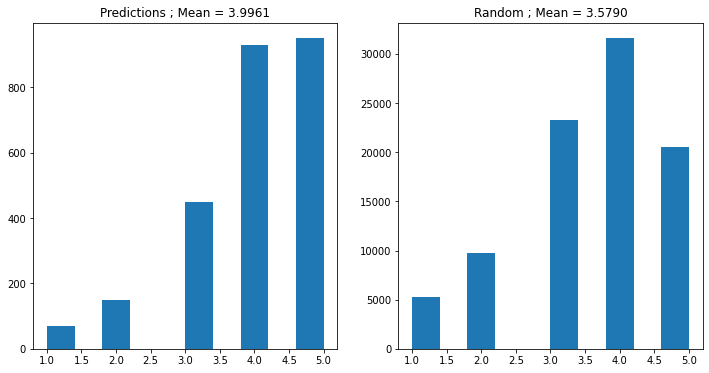

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.hist(ratings)
plt.title('Predictions ; Mean = %.4f' % (np.mean(ratings)))
plt.subplot(1, 2, 2)
plt.hist(random_seen)
plt.title('Random ; Mean = %.4f' % (np.mean(random_seen)))
plt.show()

### Test 2 - Trainset and target=True

In [ ]:
ratings, unknown, random_seen = test_actor(actor, dg.train, embeddings, dict_embeddings, ra_length, history_length, target=True, nb_rounds=10)
print('%0.1f%% unknown' % (100 * unknown / (len(ratings) + unknown)))

91.5% unknown


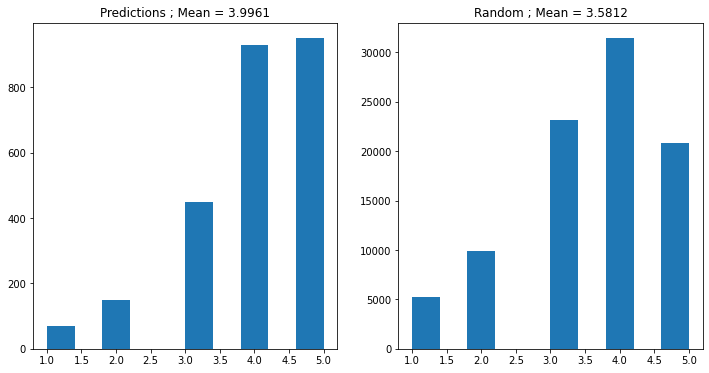

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.hist(ratings)
plt.title('Predictions ; Mean = %.4f' % (np.mean(ratings)))
plt.subplot(1, 2, 2)
plt.hist(random_seen)
plt.title('Random ; Mean = %.4f' % (np.mean(random_seen)))
plt.show()